<a href="https://colab.research.google.com/github/CoGian/NLP-with-Disaster-Tweets/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Datasets

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np 
import pandas as pd
import tensorflow as tf 
import random
import pickle 
import gc
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

In [0]:
BATCH_SIZE = 32
MAX_LEN = 30 
EPOCHS = 100

In [0]:
TARGET_COLUMN = 'target'
LOCATION_COLUMN = 'location'
KEYWORD_COLUMN = 'keyword'
METADADATA_COLUMNS = [LOCATION_COLUMN] + [KEYWORD_COLUMN]
TEXT = 'text'

TRAIN_DATASET_PATH = '/content/drive/My Drive/NLP with Disaster Tweets/data/train_cleared.csv'
TEST_DATASET_PATH = '/content/drive/My Drive/NLP with Disaster Tweets/data/test_cleared.csv'
TEST_DATASET_Y_PATH = '/content/drive/My Drive/NLP with Disaster Tweets/data/perfect-score.csv'
GLOVE_PATH = "/content/drive/My Drive/Glove/glove.840B.300d.pkl"
CRAWL_PATH = "/content/drive/My Drive/Crawl/crawl-300d-2M.pkl"

In [0]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df =  pd.read_csv(TEST_DATASET_PATH)
y_test_df = pd.read_csv(TEST_DATASET_Y_PATH)

# Prepare Data for training

## Split Dataset

In [0]:
train_df , val_df = train_test_split(train_df,test_size = 0.15,random_state = 13)

In [0]:
x_train = train_df[TEXT].astype(str)
y_train = train_df[TARGET_COLUMN].astype(int).values.reshape((-1,1))

x_val = val_df[TEXT].astype(str)
y_val = val_df[TARGET_COLUMN].astype(int).values.reshape((-1,1))

x_test = test_df[TEXT].astype(str)
y_test = y_test_df[TARGET_COLUMN].astype(int).values.reshape((-1,1))

## Create and Pad Sequences

In [0]:
#create tokenizer for our data
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_val) + list(x_test) )

In [0]:
#convert text data to numerical indexes
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)


#pad data up to MAX_LEN (note that we truncate if there are more than MAX_LEN tokens)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=MAX_LEN)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_LEN)

## Feed train set to tf.Dataset

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,{"target": y_train}))
train_dataset = train_dataset.shuffle(len(train_df)).batch(BATCH_SIZE)

## Feed validation set to tf.Dataset

In [0]:
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val,{"target": y_val}))
validation_dataset = validation_dataset.shuffle(len(val_df)).batch(BATCH_SIZE)

## Feed test set to tf.Dataset

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,{"target": y_test}))
test_dataset = test_dataset.shuffle(len(test_df)).batch(BATCH_SIZE)

## Build embeddings matrix

In [0]:
def load_embeddings(path):
    with open(path,'rb') as f:
        embedding_index = pickle.load(f)
    return embedding_index

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words 

In [0]:
glove_embedding_matrix,unknown_words = build_matrix(tokenizer.word_index,GLOVE_PATH)
print('n unknown words (glove): ', len(unknown_words))
print('n known words (glove): ', len(glove_embedding_matrix))

n unknown words (glove):  5634
n known words (glove):  27282


In [0]:
crawl_embedding_matrix,unknown_words = build_matrix(tokenizer.word_index,CRAWL_PATH)
print('n unknown words (crawl): ', len(unknown_words))
print('n known words (crawl): ', len(crawl_embedding_matrix))

n unknown words (crawl):  5689
n known words (crawl):  27282


In [0]:
embedding_matrix = np.concatenate([glove_embedding_matrix, crawl_embedding_matrix], axis=-1)
embedding_matrix.shape

(27282, 600)

In [0]:
del crawl_embedding_matrix
del glove_embedding_matrix
gc.collect()

0

In [0]:
embedding_matrix.shape

(27282, 600)

# Training and evaluation of models 

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15 , restore_best_weights=True , verbose=1)

In [0]:
def plot_history_for_accuracy_and_loss(histories):
  fig = plt.figure(figsize=(30, 20))
  outer = gridspec.GridSpec(int(len(histories)/3), 3, wspace=0.2, hspace=0.5)
  j = 1 
  for i in range(len(histories)):
    
    history = histories[i] 
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i], wspace=0.4, hspace=0.6)
    
    # summarize history for accuracy
    ax1 = plt.Subplot(fig, inner[0])
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('-----SimpleNN' + str(j) + '-' + str(int(512  / 2 ** (i%3))) + '------\n model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train', 'val'], loc='upper left')
    fig.add_subplot(ax1)
    # summarize history for loss
    ax2 = plt.Subplot(fig, inner[1])
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train', 'val'], loc='upper left')
    fig.add_subplot(ax2)

    if (i+1) % 3 == 0 : 
        j += 1
    
  fig.show()

## Simple Model 

Build model

In [0]:
def create_simple_model(embedding_matrix,num_of_hidden_layers, first_layer_units,  second_layer_units , third_layer_units,fourth_layer_units):
   words = tf.keras.Input(shape=(MAX_LEN,))
   x = tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
                                 output_dim = embedding_matrix.shape[1],
                                 weights=[embedding_matrix], trainable=False)(words)
   x = tf.keras.layers.GlobalAveragePooling1D()(x)

   if num_of_hidden_layers ==1 : 
     x = tf.keras.layers.Dense(first_layer_units,activation='relu')(x)
   elif num_of_hidden_layers==2 : 
     x = tf.keras.layers.Dense(first_layer_units,activation='relu')(x)
     x = tf.keras.layers.Dropout(0.5)(x)
     x = tf.keras.layers.Dense(second_layer_units,activation='relu')(x)
   elif num_of_hidden_layers==3 : 
     x = tf.keras.layers.Dense(first_layer_units,activation='relu')(x)
     x = tf.keras.layers.Dropout(0.5)(x)
     x = tf.keras.layers.Dense(second_layer_units,activation='relu')(x)
     x = tf.keras.layers.Dropout(0.5)(x)
     x = tf.keras.layers.Dense(third_layer_units,activation='relu')(x)
   elif num_of_hidden_layers==4 :
     x = tf.keras.layers.Dense(first_layer_units,activation='relu')(x)
     x = tf.keras.layers.Dropout(0.5)(x)
     x = tf.keras.layers.Dense(second_layer_units,activation='relu')(x)
     x = tf.keras.layers.Dropout(0.5)(x)
     x = tf.keras.layers.Dense(third_layer_units,activation='relu')(x)
     x = tf.keras.layers.Dropout(0.5)(x)
     x = tf.keras.layers.Dense(fourth_layer_units,activation='relu')(x)
   else : 
     print("Wrong number of hidden layers")

   x = tf.keras.layers.Dropout(0.5)(x)
   result = tf.keras.layers.Dense(1 , activation='sigmoid', name = 'target' )(x)
   
   model = tf.keras.Model(inputs=words, outputs=result)
   model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
   return model

Train and tune the model 

In [0]:
max_hidden_layers = 4
histories = [] 

for i in range(max_hidden_layers):
  # initial number of units in hidden layer/s 
  first__hidden_layer_units = 512
  second__hidden_layer_units = 256
  third_hidden_layer_units =  128
  fourth_hidden_layer_units = 64

  # try for 3 different number of units for hidden layers 
  for j in range(0,3):
    print("\nSimpleNN" + str(i+1)+"-"+str(first__hidden_layer_units))
    # create model 
    simpleNN = create_simple_model(embedding_matrix,i+1, first__hidden_layer_units, second__hidden_layer_units
                                   , third_hidden_layer_units , fourth_hidden_layer_units)

    # save its graph 
    tf.keras.utils.plot_model(simpleNN, show_shapes= True ,show_layer_names=False, 
                              to_file='/content/drive/My Drive/NLP with Disaster Tweets/Models/SimpleNN/SimpleNN' + 
                              str(i+1)+"-"+str(first__hidden_layer_units) +'/SimpleNN.png')
    # Image(filename='/content/drive/My Drive/NLP with Disaster Tweets/Models/SimpleNN/SimpleNN.png')
  
    # fit the model 
    history = simpleNN.fit(x = train_dataset,validation_data=validation_dataset , callbacks=[callback] , epochs = EPOCHS 
                           ,verbose = 0 )
    
    histories.append(history)

    # evaluate the model 
    test_loss , test_acc = simpleNN.evaluate(x = test_dataset , verbose = 0 )
    print("Loss on test data : {:f} ".format(test_loss))
    print("Accuracy on test data : {:f} ".format(test_acc))

    # make report and save to a csv
    y_predictions = simpleNN.predict(x= x_test)
    report = classification_report(np.where(y_test < 0.5 , "fake-disaster","real-disaster"), 
                                np.where(y_predictions < 0.5 , "fake-disaster","real-disaster")
                                , labels=["fake-disaster" , "real-disaster"],output_dict=True)  
    report_df = pd.DataFrame(report).transpose()
    report_df["loss"] = test_loss
    report_df.to_csv(r'/content/drive/My Drive/NLP with Disaster Tweets/Models/SimpleNN/SimpleNN' + 
                              str(i+1)+"-"+str(first__hidden_layer_units) + '/report.csv')
    # save the model 
    simpleNN.save_weights('/content/drive/My Drive/NLP with Disaster Tweets/Models/SimpleNN/SimpleNN' + 
                              str(i+1)+"-"+str(first__hidden_layer_units)  + '/my_checkpoint')
    # update number of units in its layer 
    first__hidden_layer_units =  int(first__hidden_layer_units / 2)
    second__hidden_layer_units = int(second__hidden_layer_units / 2)
    third_hidden_layer_units = int(third_hidden_layer_units / 2) 
    fourth_hidden_layer_units = int(fourth_hidden_layer_units / 2)


SimpleNN1-512
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Loss on test data : 0.425774 
Accuracy on test data : 0.815201 

SimpleNN1-256
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
Loss on test data : 0.421845 
Accuracy on test data : 0.818265 

SimpleNN1-128
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Loss on test data : 0.421926 
Accuracy on test data : 0.816120 

SimpleNN2-512
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Loss on test data : 0.419798 
Accuracy on test data : 0.816733 

SimpleNN2-256
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Loss on test data : 0.418544 
Accuracy on test data : 0.816427 

SimpleNN2-128
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
Loss on test data : 0.423685 
Accuracy on test data : 0.817652 

SimpleNN3-512
Restori

Plot accuracy and loss

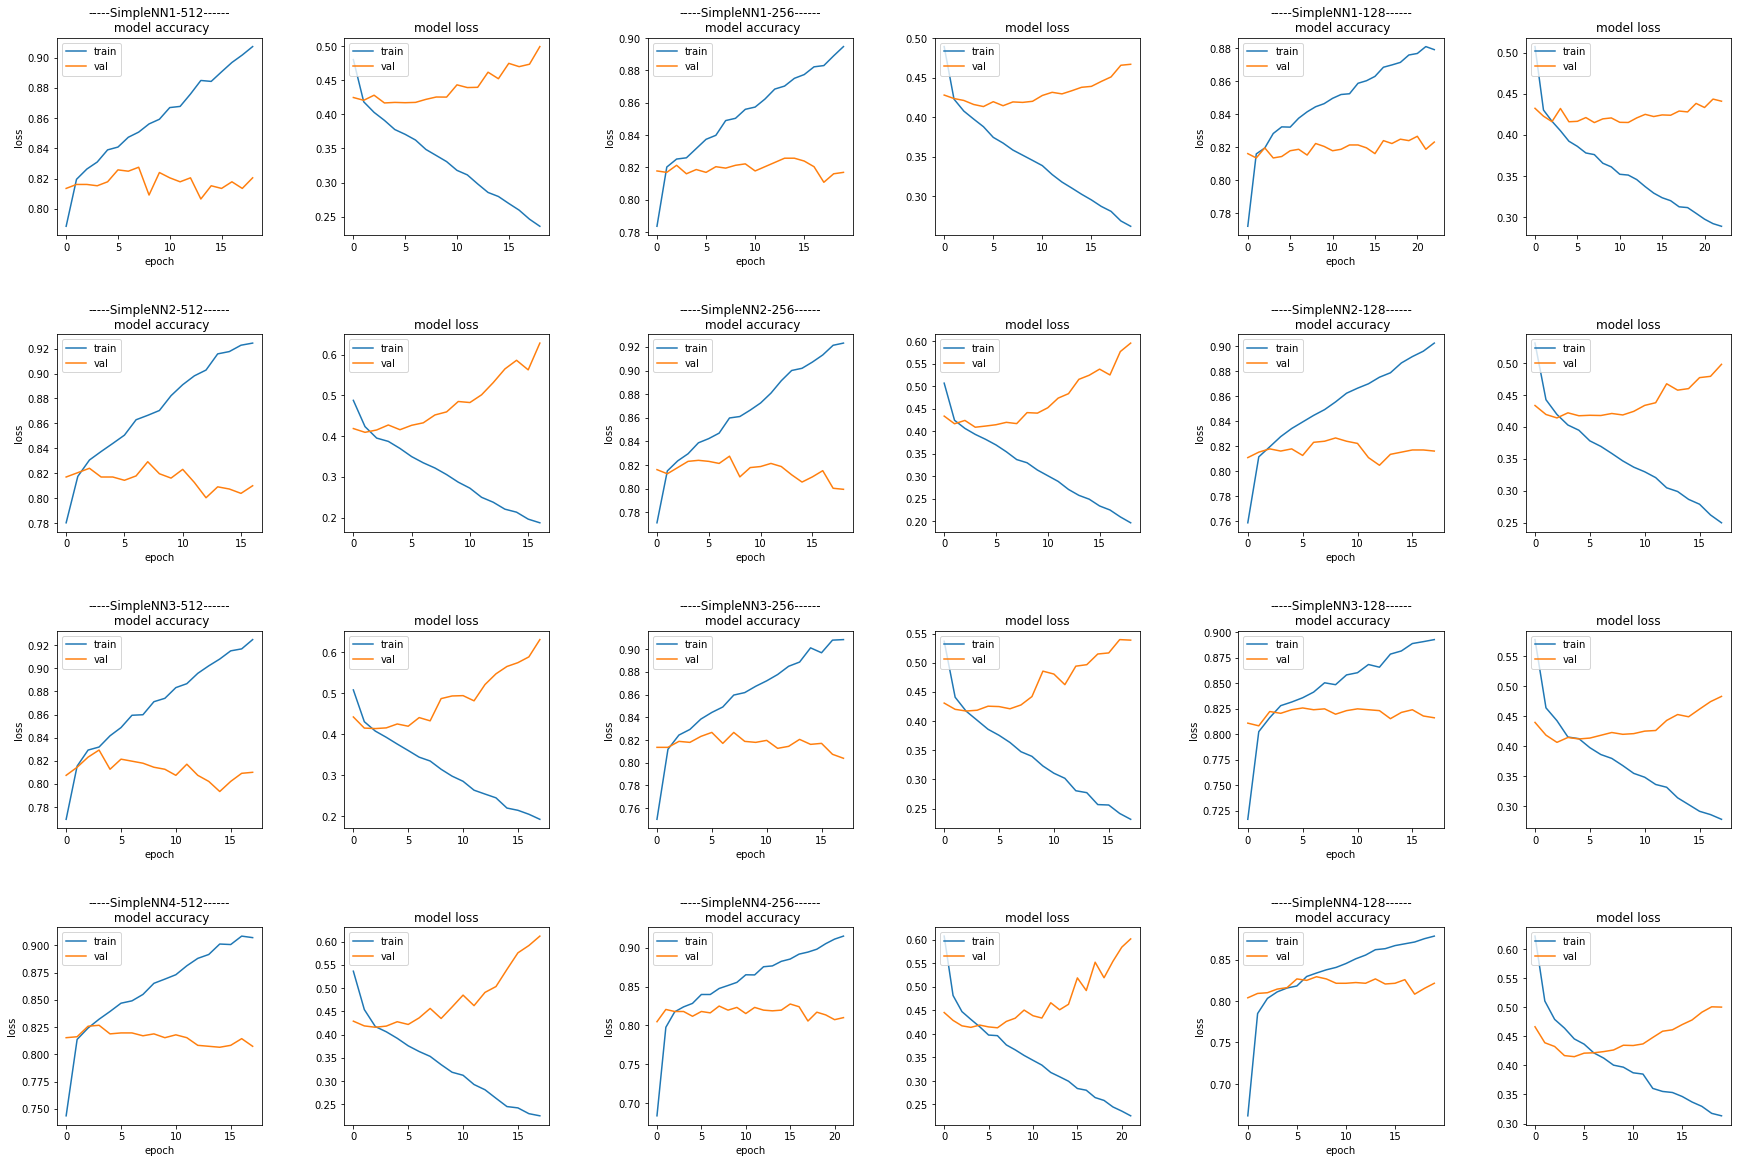

In [0]:
plot_history_for_accuracy_and_loss(histories)

## LSTM Model

In [0]:
def RNN(embedding_matrix):
  words = tf.keras.Input(shape=(MAX_LEN,))
  x = tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
                                 output_dim = embedding_matrix.shape[1],
                                 weights=[embedding_matrix], trainable=False)(words)
  x = tf.keras.layers.Dropout(0.2) (x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.2,return_sequences=True))(x)
  x = tf.keras.layers.GlobalAveragePooling1D()(x)
  x = tf.keras.layers.Dense(8,activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  result = tf.keras.layers.Dense(1, activation='sigmoid', name = 'target' )(x)
    
  model = tf.keras.Model(inputs=words, outputs=result)
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

  return model